## DNS Tunneling (Attack) detection using Machine learning

### Importing necessary libraries

In [59]:
# importing all libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt  

import warnings
warnings.filterwarnings('ignore')
import ipaddress
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score , classification_report , confusion_matrix

from sklearn.model_selection import GridSearchCV
import lightgbm as lgm

# from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import ADASYN 



#### Importing dataset

In [2]:
df = pd.read_csv('merged.csv')

In [3]:
df

,Unnamed: 0,SourceIP,DestinationIP,SourcePort,DestinationPort,TimeStamp,Duration,FlowBytesSent,FlowSentRate,FlowBytesReceived,...,PacketTimeCoefficientofVariation,ResponseTimeTimeVariance,ResponseTimeTimeStandardDeviation,ResponseTimeTimeMean,ResponseTimeTimeMedian,ResponseTimeTimeMode,ResponseTimeTimeSkewFromMedian,ResponseTimeTimeSkewFromMode,ResponseTimeTimeCoefficientofVariation,Label
0,226579,192.168.20.204,8.8.4.4,41162,443,2020-03-31 18:32:41,0.102920,1032,10027.205597,3635,...,0.482021,1.479994e-04,0.012166,0.014912,0.024740,0.000007,-2.423476,1.225219,0.815798,Malicious
1,231053,192.168.20.204,176.103.130.130,35932,443,2020-03-21 05:50:20,120.729717,51775,428.850504,104849,...,0.598926,2.379451e-02,0.154255,0.076519,0.026715,0.026623,0.968611,0.323467,2.015894,Malicious
2,113769,1.1.1.1,192.168.20.207,443,51556,2020-03-21 09:26:21,7.072765,3039,429.676371,1568,...,0.484357,2.411757e-01,0.491096,0.454689,0.000042,0.000010,2.777341,0.925846,1.080070,Malicious
3,213570,192.168.20.204,9.9.9.11,51928,443,2020-03-30 22:22:21,0.266430,985,3697.031115,3872,...,0.996055,6.503893e-05,0.008065,0.013735,0.016514,0.000297,-1.033675,1.666311,0.587151,Malicious
4,236745,192.168.20.144,8.8.4.4,36970,443,2020-03-24 00:20:37,105.743372,544,5.144530,544,...,0.654482,1.833040e-05,0.004281,0.022753,0.025059,0.015338,-1.615826,1.732026,0.188165,Malicious
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269638,4974,192.168.20.111,8.8.8.8,42836,443,2019-12-14 19:37:09,4.178136,498,119.191908,353,...,0.652330,3.208526e+00,1.791236,1.044430,0.015389,0.000020,1.723460,0.583067,1.715037,Benign
269639,82457,192.168.20.144,9.9.9.11,48000,443,2020-03-30 21:14:01,0.181570,917,5050.393788,3804,...,0.874299,1.058326e-06,0.001029,0.016745,0.016446,0.015662,0.872904,1.053058,0.061435,Malicious
269640,173654,192.168.20.144,1.1.1.1,32820,443,2020-04-01 22:13:36,105.743029,448,4.236686,372,...,0.592112,1.542158e-08,0.000124,0.015081,0.015064,0.014944,0.386524,1.099178,0.008235,Malicious
269641,47745,176.103.130.130,192.168.20.144,443,54186,2020-03-22 17:43:47,0.026779,329,12285.746294,296,...,2.579585,3.034889e-09,0.000055,0.000055,0.000029,0.000005,1.434022,0.913659,0.995599,Malicious


In [4]:
# pd.set_option('display.max_columns', None)

In [5]:
# df.head()

In [6]:
df.shape

(269643, 36)

**Dataset containing 269643 rows and 36 columns**

**Data types of columns(features)**

In [7]:
df.dtypes

Unnamed: 0                                  int64
SourceIP                                   object
DestinationIP                              object
SourcePort                                  int64
DestinationPort                             int64
TimeStamp                                  object
Duration                                  float64
FlowBytesSent                               int64
FlowSentRate                              float64
FlowBytesReceived                           int64
FlowReceivedRate                          float64
PacketLengthVariance                      float64
PacketLengthStandardDeviation             float64
PacketLengthMean                          float64
PacketLengthMedian                        float64
PacketLengthMode                            int64
PacketLengthSkewFromMedian                float64
PacketLengthSkewFromMode                  float64
PacketLengthCoefficientofVariation        float64
PacketTimeVariance                        float64


**Removing unnecessary columns**

In [8]:
df.drop(['Unnamed: 0','TimeStamp'] , axis=1 , inplace=True)

In [9]:
df

,SourceIP,DestinationIP,SourcePort,DestinationPort,Duration,FlowBytesSent,FlowSentRate,FlowBytesReceived,FlowReceivedRate,PacketLengthVariance,...,PacketTimeCoefficientofVariation,ResponseTimeTimeVariance,ResponseTimeTimeStandardDeviation,ResponseTimeTimeMean,ResponseTimeTimeMedian,ResponseTimeTimeMode,ResponseTimeTimeSkewFromMedian,ResponseTimeTimeSkewFromMode,ResponseTimeTimeCoefficientofVariation,Label
0,192.168.20.204,8.8.4.4,41162,443,0.102920,1032,10027.205597,3635,35318.694131,270099.964844,...,0.482021,1.479994e-04,0.012166,0.014912,0.024740,0.000007,-2.423476,1.225219,0.815798,Malicious
1,192.168.20.204,176.103.130.130,35932,443,120.729717,51775,428.850504,104849,868.460580,50845.484862,...,0.598926,2.379451e-02,0.154255,0.076519,0.026715,0.026623,0.968611,0.323467,2.015894,Malicious
2,1.1.1.1,192.168.20.207,443,51556,7.072765,3039,429.676371,1568,221.695476,4724.759695,...,0.484357,2.411757e-01,0.491096,0.454689,0.000042,0.000010,2.777341,0.925846,1.080070,Malicious
3,192.168.20.204,9.9.9.11,51928,443,0.266430,985,3697.031115,3872,14532.897947,271083.494898,...,0.996055,6.503893e-05,0.008065,0.013735,0.016514,0.000297,-1.033675,1.666311,0.587151,Malicious
4,192.168.20.144,8.8.4.4,36970,443,105.743372,544,5.144530,544,5.144530,0.000000,...,0.654482,1.833040e-05,0.004281,0.022753,0.025059,0.015338,-1.615826,1.732026,0.188165,Malicious
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269638,192.168.20.111,8.8.8.8,42836,443,4.178136,498,119.191908,353,84.487437,466.290000,...,0.652330,3.208526e+00,1.791236,1.044430,0.015389,0.000020,1.723460,0.583067,1.715037,Benign
269639,192.168.20.144,9.9.9.11,48000,443,0.181570,917,5050.393788,3804,20950.597566,679064.076389,...,0.874299,1.058326e-06,0.001029,0.016745,0.016446,0.015662,0.872904,1.053058,0.061435,Malicious
269640,192.168.20.144,1.1.1.1,32820,443,105.743029,448,4.236686,372,3.517962,8.816327,...,0.592112,1.542158e-08,0.000124,0.015081,0.015064,0.014944,0.386524,1.099178,0.008235,Malicious
269641,176.103.130.130,192.168.20.144,443,54186,0.026779,329,12285.746294,296,11053.437395,236.109375,...,2.579585,3.034889e-09,0.000055,0.000055,0.000029,0.000005,1.434022,0.913659,0.995599,Malicious


**We have to handle IP addresses .... So we convert them to integer**

In [10]:
a = []
for i in df['SourceIP']:
    b = int(ipaddress.IPv4Address(i))
    a.append(b)
    
df['SourceIP'] = a

In [11]:
df

,SourceIP,DestinationIP,SourcePort,DestinationPort,Duration,FlowBytesSent,FlowSentRate,FlowBytesReceived,FlowReceivedRate,PacketLengthVariance,...,PacketTimeCoefficientofVariation,ResponseTimeTimeVariance,ResponseTimeTimeStandardDeviation,ResponseTimeTimeMean,ResponseTimeTimeMedian,ResponseTimeTimeMode,ResponseTimeTimeSkewFromMedian,ResponseTimeTimeSkewFromMode,ResponseTimeTimeCoefficientofVariation,Label
0,3232240844,8.8.4.4,41162,443,0.102920,1032,10027.205597,3635,35318.694131,270099.964844,...,0.482021,1.479994e-04,0.012166,0.014912,0.024740,0.000007,-2.423476,1.225219,0.815798,Malicious
1,3232240844,176.103.130.130,35932,443,120.729717,51775,428.850504,104849,868.460580,50845.484862,...,0.598926,2.379451e-02,0.154255,0.076519,0.026715,0.026623,0.968611,0.323467,2.015894,Malicious
2,16843009,192.168.20.207,443,51556,7.072765,3039,429.676371,1568,221.695476,4724.759695,...,0.484357,2.411757e-01,0.491096,0.454689,0.000042,0.000010,2.777341,0.925846,1.080070,Malicious
3,3232240844,9.9.9.11,51928,443,0.266430,985,3697.031115,3872,14532.897947,271083.494898,...,0.996055,6.503893e-05,0.008065,0.013735,0.016514,0.000297,-1.033675,1.666311,0.587151,Malicious
4,3232240784,8.8.4.4,36970,443,105.743372,544,5.144530,544,5.144530,0.000000,...,0.654482,1.833040e-05,0.004281,0.022753,0.025059,0.015338,-1.615826,1.732026,0.188165,Malicious
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269638,3232240751,8.8.8.8,42836,443,4.178136,498,119.191908,353,84.487437,466.290000,...,0.652330,3.208526e+00,1.791236,1.044430,0.015389,0.000020,1.723460,0.583067,1.715037,Benign
269639,3232240784,9.9.9.11,48000,443,0.181570,917,5050.393788,3804,20950.597566,679064.076389,...,0.874299,1.058326e-06,0.001029,0.016745,0.016446,0.015662,0.872904,1.053058,0.061435,Malicious
269640,3232240784,1.1.1.1,32820,443,105.743029,448,4.236686,372,3.517962,8.816327,...,0.592112,1.542158e-08,0.000124,0.015081,0.015064,0.014944,0.386524,1.099178,0.008235,Malicious
269641,2959573634,192.168.20.144,443,54186,0.026779,329,12285.746294,296,11053.437395,236.109375,...,2.579585,3.034889e-09,0.000055,0.000055,0.000029,0.000005,1.434022,0.913659,0.995599,Malicious


In [12]:
a = []
for i in df['DestinationIP']:
    b = int(ipaddress.IPv4Address(i))
    a.append(b)
    
df['DestinationIP'] = a

In [13]:
df

,SourceIP,DestinationIP,SourcePort,DestinationPort,Duration,FlowBytesSent,FlowSentRate,FlowBytesReceived,FlowReceivedRate,PacketLengthVariance,...,PacketTimeCoefficientofVariation,ResponseTimeTimeVariance,ResponseTimeTimeStandardDeviation,ResponseTimeTimeMean,ResponseTimeTimeMedian,ResponseTimeTimeMode,ResponseTimeTimeSkewFromMedian,ResponseTimeTimeSkewFromMode,ResponseTimeTimeCoefficientofVariation,Label
0,3232240844,134743044,41162,443,0.102920,1032,10027.205597,3635,35318.694131,270099.964844,...,0.482021,1.479994e-04,0.012166,0.014912,0.024740,0.000007,-2.423476,1.225219,0.815798,Malicious
1,3232240844,2959573634,35932,443,120.729717,51775,428.850504,104849,868.460580,50845.484862,...,0.598926,2.379451e-02,0.154255,0.076519,0.026715,0.026623,0.968611,0.323467,2.015894,Malicious
2,16843009,3232240847,443,51556,7.072765,3039,429.676371,1568,221.695476,4724.759695,...,0.484357,2.411757e-01,0.491096,0.454689,0.000042,0.000010,2.777341,0.925846,1.080070,Malicious
3,3232240844,151587083,51928,443,0.266430,985,3697.031115,3872,14532.897947,271083.494898,...,0.996055,6.503893e-05,0.008065,0.013735,0.016514,0.000297,-1.033675,1.666311,0.587151,Malicious
4,3232240784,134743044,36970,443,105.743372,544,5.144530,544,5.144530,0.000000,...,0.654482,1.833040e-05,0.004281,0.022753,0.025059,0.015338,-1.615826,1.732026,0.188165,Malicious
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269638,3232240751,134744072,42836,443,4.178136,498,119.191908,353,84.487437,466.290000,...,0.652330,3.208526e+00,1.791236,1.044430,0.015389,0.000020,1.723460,0.583067,1.715037,Benign
269639,3232240784,151587083,48000,443,0.181570,917,5050.393788,3804,20950.597566,679064.076389,...,0.874299,1.058326e-06,0.001029,0.016745,0.016446,0.015662,0.872904,1.053058,0.061435,Malicious
269640,3232240784,16843009,32820,443,105.743029,448,4.236686,372,3.517962,8.816327,...,0.592112,1.542158e-08,0.000124,0.015081,0.015064,0.014944,0.386524,1.099178,0.008235,Malicious
269641,2959573634,3232240784,443,54186,0.026779,329,12285.746294,296,11053.437395,236.109375,...,2.579585,3.034889e-09,0.000055,0.000055,0.000029,0.000005,1.434022,0.913659,0.995599,Malicious


**Shuffling the dataset**

In [14]:
df.sample(frac=1)

,SourceIP,DestinationIP,SourcePort,DestinationPort,Duration,FlowBytesSent,FlowSentRate,FlowBytesReceived,FlowReceivedRate,PacketLengthVariance,...,PacketTimeCoefficientofVariation,ResponseTimeTimeVariance,ResponseTimeTimeStandardDeviation,ResponseTimeTimeMean,ResponseTimeTimeMedian,ResponseTimeTimeMode,ResponseTimeTimeSkewFromMedian,ResponseTimeTimeSkewFromMode,ResponseTimeTimeCoefficientofVariation,Label
174054,134743044,3232240850,443,49014,120.779242,309279,2560.696647,194182,1607.743158,6490.874389,...,0.680353,0.029649,0.172188,0.033239,0.000039,0.000002,0.578442,0.193029,5.180258,Malicious
125989,3232240844,151587083,42458,443,34.104814,1806,52.954401,4827,141.534271,145425.992866,...,1.592702,0.000324,0.017990,0.017514,0.015370,0.015370,0.357465,0.119155,1.027214,Malicious
180037,3232240845,151587083,44644,443,34.020713,5779,169.867104,8520,250.435668,211450.643690,...,1.965647,0.000056,0.007468,0.010018,0.015444,0.000043,-2.179613,1.335715,0.745449,Malicious
51596,3232240844,151587083,34598,443,33.539714,1807,53.876428,4896,145.976200,141502.778889,...,1.638540,0.000053,0.007273,0.010376,0.015515,0.000021,-2.119986,1.423820,0.700914,Malicious
32837,134743044,3232240851,443,37140,120.019410,572901,4773.402902,282805,2356.327197,6879.882171,...,0.572511,0.007102,0.084276,0.016550,0.000050,0.000033,0.587368,0.195991,5.092103,Malicious
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86339,134743044,3232240784,443,36256,105.728107,544,5.145273,476,4.502114,0.000000,...,0.582574,0.000006,0.002486,15.077871,15.078868,15.071783,-1.203871,2.449181,0.000165,Malicious
115259,134743044,3232240852,443,40300,120.014112,734429,6119.522011,344030,2866.579557,8667.077713,...,0.580023,0.000272,0.016486,0.012054,0.000051,0.000030,2.184231,0.729351,1.367670,Malicious
185629,3232240844,134743044,46000,443,0.138081,1100,7966.338598,3703,26817.592572,194455.361111,...,0.540789,0.000152,0.012340,0.012633,0.012672,0.000005,-0.009563,1.023373,0.976774,Malicious
213243,3232240845,2959573634,48368,443,121.126021,30209,249.401406,52385,432.483455,39053.243699,...,0.521381,0.561641,0.749427,0.319880,0.026195,0.000011,1.175639,0.426818,2.342836,Malicious


**Checking for Null Values**

In [15]:
df.isnull().sum()

SourceIP                                    0
DestinationIP                               0
SourcePort                                  0
DestinationPort                             0
Duration                                    0
FlowBytesSent                               0
FlowSentRate                                0
FlowBytesReceived                           0
FlowReceivedRate                            0
PacketLengthVariance                        0
PacketLengthStandardDeviation               0
PacketLengthMean                            0
PacketLengthMedian                          0
PacketLengthMode                            0
PacketLengthSkewFromMedian                  0
PacketLengthSkewFromMode                    0
PacketLengthCoefficientofVariation          0
PacketTimeVariance                          0
PacketTimeStandardDeviation                 0
PacketTimeMean                              0
PacketTimeMedian                            0
PacketTimeMode                    

**Two columns (variables) containing null values**

**Handling Null values using mean of that column(feature)**

In [16]:
df['ResponseTimeTimeMedian'] = df['ResponseTimeTimeMedian'].fillna(df['ResponseTimeTimeMedian'].mean())


df['ResponseTimeTimeSkewFromMedian'] = df['ResponseTimeTimeSkewFromMedian'].fillna(df['ResponseTimeTimeSkewFromMedian'].mean())

In [17]:
df.isnull().sum()

SourceIP                                  0
DestinationIP                             0
SourcePort                                0
DestinationPort                           0
Duration                                  0
FlowBytesSent                             0
FlowSentRate                              0
FlowBytesReceived                         0
FlowReceivedRate                          0
PacketLengthVariance                      0
PacketLengthStandardDeviation             0
PacketLengthMean                          0
PacketLengthMedian                        0
PacketLengthMode                          0
PacketLengthSkewFromMedian                0
PacketLengthSkewFromMode                  0
PacketLengthCoefficientofVariation        0
PacketTimeVariance                        0
PacketTimeStandardDeviation               0
PacketTimeMean                            0
PacketTimeMedian                          0
PacketTimeMode                            0
PacketTimeSkewFromMedian        

In [18]:
df['Label']

0         Malicious
1         Malicious
2         Malicious
3         Malicious
4         Malicious
            ...    
269638       Benign
269639    Malicious
269640    Malicious
269641    Malicious
269642    Malicious
Name: Label, Length: 269643, dtype: object

In [19]:
df['Label'].value_counts()

Malicious    249836
Benign        19807
Name: Label, dtype: int64

In [20]:
df['Label'].unique()

array(['Malicious', 'Benign'], dtype=object)

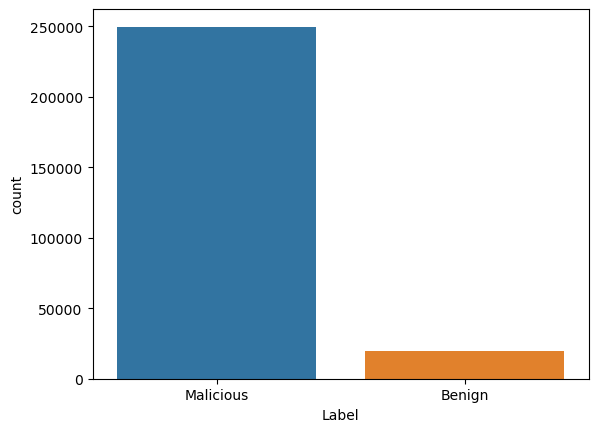

In [21]:
sns.countplot(df['Label'])
plt.show()

**Converting Target variable(Label) into integer using Label Encoder**

In [22]:
en = LabelEncoder()

In [23]:
df['Label'] = en.fit_transform(df['Label'])

In [24]:
df['Label']

0         1
1         1
2         1
3         1
4         1
         ..
269638    0
269639    1
269640    1
269641    1
269642    1
Name: Label, Length: 269643, dtype: int32

In [25]:
df['Label'].unique()

array([1, 0])

In [26]:
df['Label'].value_counts()

1    249836
0     19807
Name: Label, dtype: int64

**Seperating independent and dependent(target) variables**

In [27]:
x = df.drop('Label' , axis=1)
y = df.Label

In [28]:
x.shape

(269643, 33)

In [29]:
y.shape

(269643,)

In [30]:
x

,SourceIP,DestinationIP,SourcePort,DestinationPort,Duration,FlowBytesSent,FlowSentRate,FlowBytesReceived,FlowReceivedRate,PacketLengthVariance,...,PacketTimeSkewFromMode,PacketTimeCoefficientofVariation,ResponseTimeTimeVariance,ResponseTimeTimeStandardDeviation,ResponseTimeTimeMean,ResponseTimeTimeMedian,ResponseTimeTimeMode,ResponseTimeTimeSkewFromMedian,ResponseTimeTimeSkewFromMode,ResponseTimeTimeCoefficientofVariation
0,3232240844,134743044,41162,443,0.102920,1032,10027.205597,3635,35318.694131,270099.964844,...,2.074597,0.482021,1.479994e-04,0.012166,0.014912,0.024740,0.000007,-2.423476,1.225219,0.815798
1,3232240844,2959573634,35932,443,120.729717,51775,428.850504,104849,868.460580,50845.484862,...,1.669654,0.598926,2.379451e-02,0.154255,0.076519,0.026715,0.026623,0.968611,0.323467,2.015894
2,16843009,3232240847,443,51556,7.072765,3039,429.676371,1568,221.695476,4724.759695,...,2.064594,0.484357,2.411757e-01,0.491096,0.454689,0.000042,0.000010,2.777341,0.925846,1.080070
3,3232240844,151587083,51928,443,0.266430,985,3697.031115,3872,14532.897947,271083.494898,...,1.003961,0.996055,6.503893e-05,0.008065,0.013735,0.016514,0.000297,-1.033675,1.666311,0.587151
4,3232240784,134743044,36970,443,105.743372,544,5.144530,544,5.144530,0.000000,...,1.527926,0.654482,1.833040e-05,0.004281,0.022753,0.025059,0.015338,-1.615826,1.732026,0.188165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269638,3232240751,134744072,42836,443,4.178136,498,119.191908,353,84.487437,466.290000,...,1.532967,0.652330,3.208526e+00,1.791236,1.044430,0.015389,0.000020,1.723460,0.583067,1.715037
269639,3232240784,151587083,48000,443,0.181570,917,5050.393788,3804,20950.597566,679064.076389,...,1.143773,0.874299,1.058326e-06,0.001029,0.016745,0.016446,0.015662,0.872904,1.053058,0.061435
269640,3232240784,16843009,32820,443,105.743029,448,4.236686,372,3.517962,8.816327,...,1.688869,0.592112,1.542158e-08,0.000124,0.015081,0.015064,0.014944,0.386524,1.099178,0.008235
269641,2959573634,3232240784,443,54186,0.026779,329,12285.746294,296,11053.437395,236.109375,...,0.387659,2.579585,3.034889e-09,0.000055,0.000055,0.000029,0.000005,1.434022,0.913659,0.995599


In [31]:
y

0         1
1         1
2         1
3         1
4         1
         ..
269638    0
269639    1
269640    1
269641    1
269642    1
Name: Label, Length: 269643, dtype: int32

**Checking data is balanced or not**

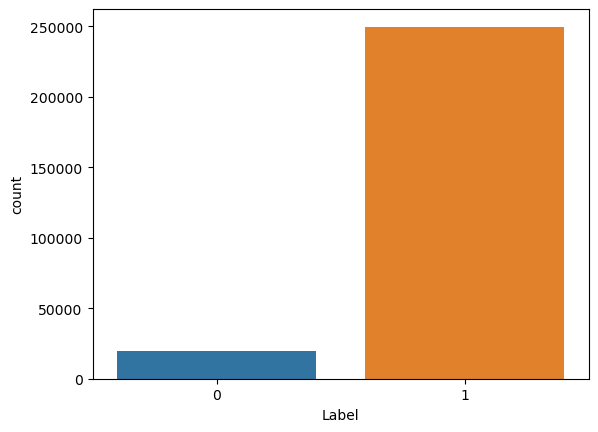

In [32]:
sns.countplot(y)

plt.show()

### Splitting data into training and testing

In [35]:
x_train , x_test , y_train , y_test = train_test_split(x,y,test_size=0.33 , random_state=42)

In [36]:
x_train.shape , x_test.shape , y_train.shape , y_test.shape

((180660, 33), (88983, 33), (180660,), (88983,))

In [37]:
x_train

,SourceIP,DestinationIP,SourcePort,DestinationPort,Duration,FlowBytesSent,FlowSentRate,FlowBytesReceived,FlowReceivedRate,PacketLengthVariance,...,PacketTimeSkewFromMode,PacketTimeCoefficientofVariation,ResponseTimeTimeVariance,ResponseTimeTimeStandardDeviation,ResponseTimeTimeMean,ResponseTimeTimeMedian,ResponseTimeTimeMode,ResponseTimeTimeSkewFromMedian,ResponseTimeTimeSkewFromMode,ResponseTimeTimeCoefficientofVariation
175878,134743044,3232240848,443,43610,120.498029,224355,1861.897675,127230,1055.867893,7158.270918,...,1.093624,0.808937,0.107084,0.327237,0.084768,0.000042,0.000013,0.776742,0.259003,3.860371
230563,3232240844,151587083,39976,443,0.204325,1085,5310.167625,4032,19733.268078,224634.645062,...,1.335661,0.748693,0.000066,0.008107,0.008950,0.008753,0.000025,0.072838,1.100880,0.905827
37501,3232240848,151587083,46346,443,34.088127,1875,55.004489,4896,143.627721,126668.888658,...,0.599817,1.667174,0.000060,0.007732,0.009625,0.015450,0.000024,-2.260113,1.241839,0.803249
113979,3232240784,151587083,60520,443,34.100154,3726,109.266369,6776,198.708780,82540.805213,...,0.519346,1.925500,0.000085,0.009234,0.010871,0.013706,0.000018,-0.920945,1.175313,0.849429
237868,3232240784,151587083,37296,443,18.318387,1510,82.430838,4550,248.384315,388678.247934,...,0.381383,2.622033,0.000033,0.005718,0.013109,0.015496,0.000334,-1.252846,2.234014,0.436219
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119879,3232240784,151587083,58086,443,33.584279,1739,51.780180,4760,141.732982,322210.652949,...,0.657243,1.521508,0.000045,0.006716,0.011642,0.015397,0.000010,-1.677790,1.731991,0.576874
259178,3232240852,151587083,58786,443,34.436756,1951,56.654582,4895,142.144632,123326.308594,...,0.656540,1.523137,0.000057,0.007544,0.009447,0.015317,0.000023,-2.334524,1.249184,0.798574
131932,3232240850,151587083,54312,443,33.363329,5392,161.614568,8088,242.421852,153368.828775,...,0.476426,2.098962,0.000061,0.007818,0.007522,0.001013,0.000004,2.497572,0.961588,1.039393
146867,3232240844,151587083,57134,443,33.761809,4285,126.918555,7025,208.075343,78429.103448,...,0.511025,1.956851,0.000054,0.007359,0.006860,0.001285,0.000032,2.273028,0.927875,1.072704


In [38]:
x_test

,SourceIP,DestinationIP,SourcePort,DestinationPort,Duration,FlowBytesSent,FlowSentRate,FlowBytesReceived,FlowReceivedRate,PacketLengthVariance,...,PacketTimeSkewFromMode,PacketTimeCoefficientofVariation,ResponseTimeTimeVariance,ResponseTimeTimeStandardDeviation,ResponseTimeTimeMean,ResponseTimeTimeMedian,ResponseTimeTimeMode,ResponseTimeTimeSkewFromMedian,ResponseTimeTimeSkewFromMode,ResponseTimeTimeCoefficientofVariation
77826,3232240850,151587083,56514,443,34.084361,1807,53.015516,4828,141.648541,145520.370987,...,0.627572,1.593442,5.266473e-05,0.007257,0.010387,0.015370,0.000085,-2.060067,1.419540,0.698689
97048,3232240847,134743044,57994,443,94.775271,496030,5233.749213,853055,9000.818367,8607.636728,...,-0.340695,0.575955,5.825777e-05,0.007633,0.008732,0.014771,0.000052,-2.373583,1.137225,0.874097
142036,3232240784,2959573634,50812,443,121.533168,12456,102.490540,22277,183.299756,99845.886771,...,1.319306,0.757974,5.735411e-02,0.239487,0.163602,0.029988,0.026663,1.673754,0.571800,1.463843
36369,3232240852,151587083,40682,443,33.883927,1807,53.329120,4895,144.463775,141408.773333,...,0.612474,1.632721,5.477343e-05,0.007401,0.010531,0.015263,0.000027,-1.918008,1.419331,0.702751
114156,2959573634,3232240784,443,40646,119.537443,805,6.734292,772,6.458227,109.580579,...,2.031735,0.492190,5.051662e+01,7.107504,10.051577,15.077268,0.000005,-2.121289,1.414220,0.707103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17968,3232240784,134743044,42578,443,120.140476,23760,197.768486,44716,372.197626,16811.455657,...,1.474786,0.678064,4.529735e-04,0.021283,0.017427,0.015328,0.015325,0.295909,0.098777,1.221255
141289,3232240753,2959573634,41708,443,177.001453,618,3.491497,315,1.779646,319.410000,...,1.225211,0.816186,2.745976e-07,0.000524,0.022108,0.021812,0.021667,1.692682,0.840934,0.023703
249851,3232240784,151587083,60684,443,90.047852,102178,1134.707800,185225,2056.961892,18285.187763,...,1.677287,0.596201,1.791592e-05,0.004233,0.016506,0.015584,0.015403,0.652930,0.260523,0.256440
157228,3232240751,134744072,43330,443,0.015586,171,10971.384576,105,6736.815090,338.000000,...,1.414213,0.707107,0.000000e+00,0.000000,0.015566,0.015566,0.015566,-10.000000,-10.000000,0.000000


In [39]:
y_train

175878    1
230563    1
37501     1
113979    1
237868    1
         ..
119879    1
259178    1
131932    1
146867    1
121958    1
Name: Label, Length: 180660, dtype: int32

In [40]:
y_test

77826     1
97048     1
142036    1
36369     1
114156    1
         ..
17968     1
141289    0
249851    1
157228    0
240606    1
Name: Label, Length: 88983, dtype: int32

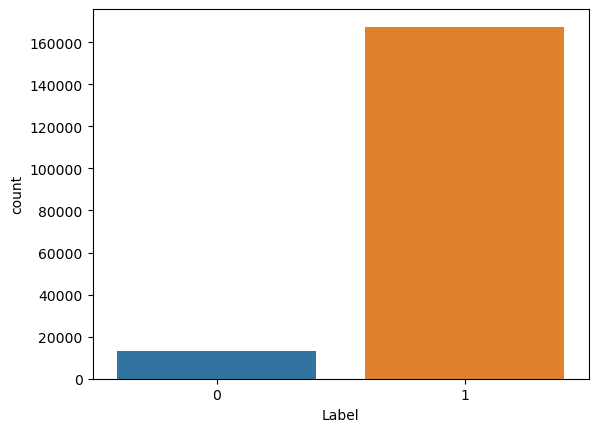

In [41]:
sns.countplot(y_train)
plt.show()

**Correlation Matrix**

In [44]:
corr = x_train.corr()

In [45]:
corr

,SourceIP,DestinationIP,SourcePort,DestinationPort,Duration,FlowBytesSent,FlowSentRate,FlowBytesReceived,FlowReceivedRate,PacketLengthVariance,...,PacketTimeSkewFromMode,PacketTimeCoefficientofVariation,ResponseTimeTimeVariance,ResponseTimeTimeStandardDeviation,ResponseTimeTimeMean,ResponseTimeTimeMedian,ResponseTimeTimeMode,ResponseTimeTimeSkewFromMedian,ResponseTimeTimeSkewFromMode,ResponseTimeTimeCoefficientofVariation
SourceIP,1.000000,-0.777916,0.842893,-0.897111,-0.425062,-0.443599,-0.053387,-0.158018,-0.042209,0.337910,...,-0.195602,0.386670,-0.069290,-0.084665,-0.339338,-0.309370,-0.321940,-0.214880,0.073470,-0.341876
DestinationIP,-0.777916,1.000000,-0.801405,0.842277,0.539895,0.340475,0.069162,0.107997,0.062143,-0.345841,...,0.295110,-0.463783,0.221189,0.249126,0.396974,0.400568,0.286491,0.224894,-0.129871,0.296232
SourcePort,0.842893,-0.801405,1.000000,-0.912630,-0.451518,-0.378064,-0.074731,-0.127358,-0.066464,0.349755,...,-0.236021,0.397073,-0.243556,-0.262500,-0.428454,-0.433672,-0.309617,-0.164468,0.082077,-0.289769
DestinationPort,-0.897111,0.842277,-0.912630,1.000000,0.459740,0.394309,0.078082,0.123879,0.069117,-0.363230,...,0.241283,-0.420033,0.259891,0.277462,0.459603,0.464381,0.335442,0.172529,-0.086200,0.307460
Duration,-0.425062,0.539895,-0.451518,0.459740,1.000000,0.391061,-0.046632,0.395427,-0.067679,-0.556203,...,0.252036,-0.440309,0.097272,0.115879,0.210357,0.212560,0.160114,0.281861,-0.025668,0.203640
FlowBytesSent,-0.443599,0.340475,-0.378064,0.394309,0.391061,1.000000,-0.003931,0.805829,-0.006840,-0.257662,...,0.048590,-0.305560,-0.059521,-0.069234,-0.079670,-0.076881,-0.054062,0.174049,-0.090574,0.449623
FlowSentRate,-0.053387,0.069162,-0.074731,0.078082,-0.046632,-0.003931,1.000000,-0.006848,0.937278,-0.033171,...,0.000358,-0.013456,-0.008235,-0.011400,-0.011264,-0.010489,-0.007396,-0.190377,-0.272253,-0.019924
FlowBytesReceived,-0.158018,0.107997,-0.127358,0.123879,0.395427,0.805829,-0.006848,1.000000,-0.004341,-0.259131,...,0.077818,-0.311659,-0.063239,-0.077346,-0.085671,-0.081396,-0.057127,0.124396,-0.088266,0.239939
FlowReceivedRate,-0.042209,0.062143,-0.066464,0.069117,-0.067679,-0.006840,0.937278,-0.004341,1.000000,-0.008961,...,0.018927,-0.031685,-0.012344,-0.016880,-0.016825,-0.015682,-0.011098,-0.200149,-0.278156,-0.025620
PacketLengthVariance,0.337910,-0.345841,0.349755,-0.363230,-0.556203,-0.257662,-0.033171,-0.259131,-0.008961,1.000000,...,-0.124389,0.256931,-0.101065,-0.097935,-0.192954,-0.203704,-0.145885,-0.041419,0.235441,-0.141238


**Plotting Correlation using Heatmap**

<AxesSubplot:>

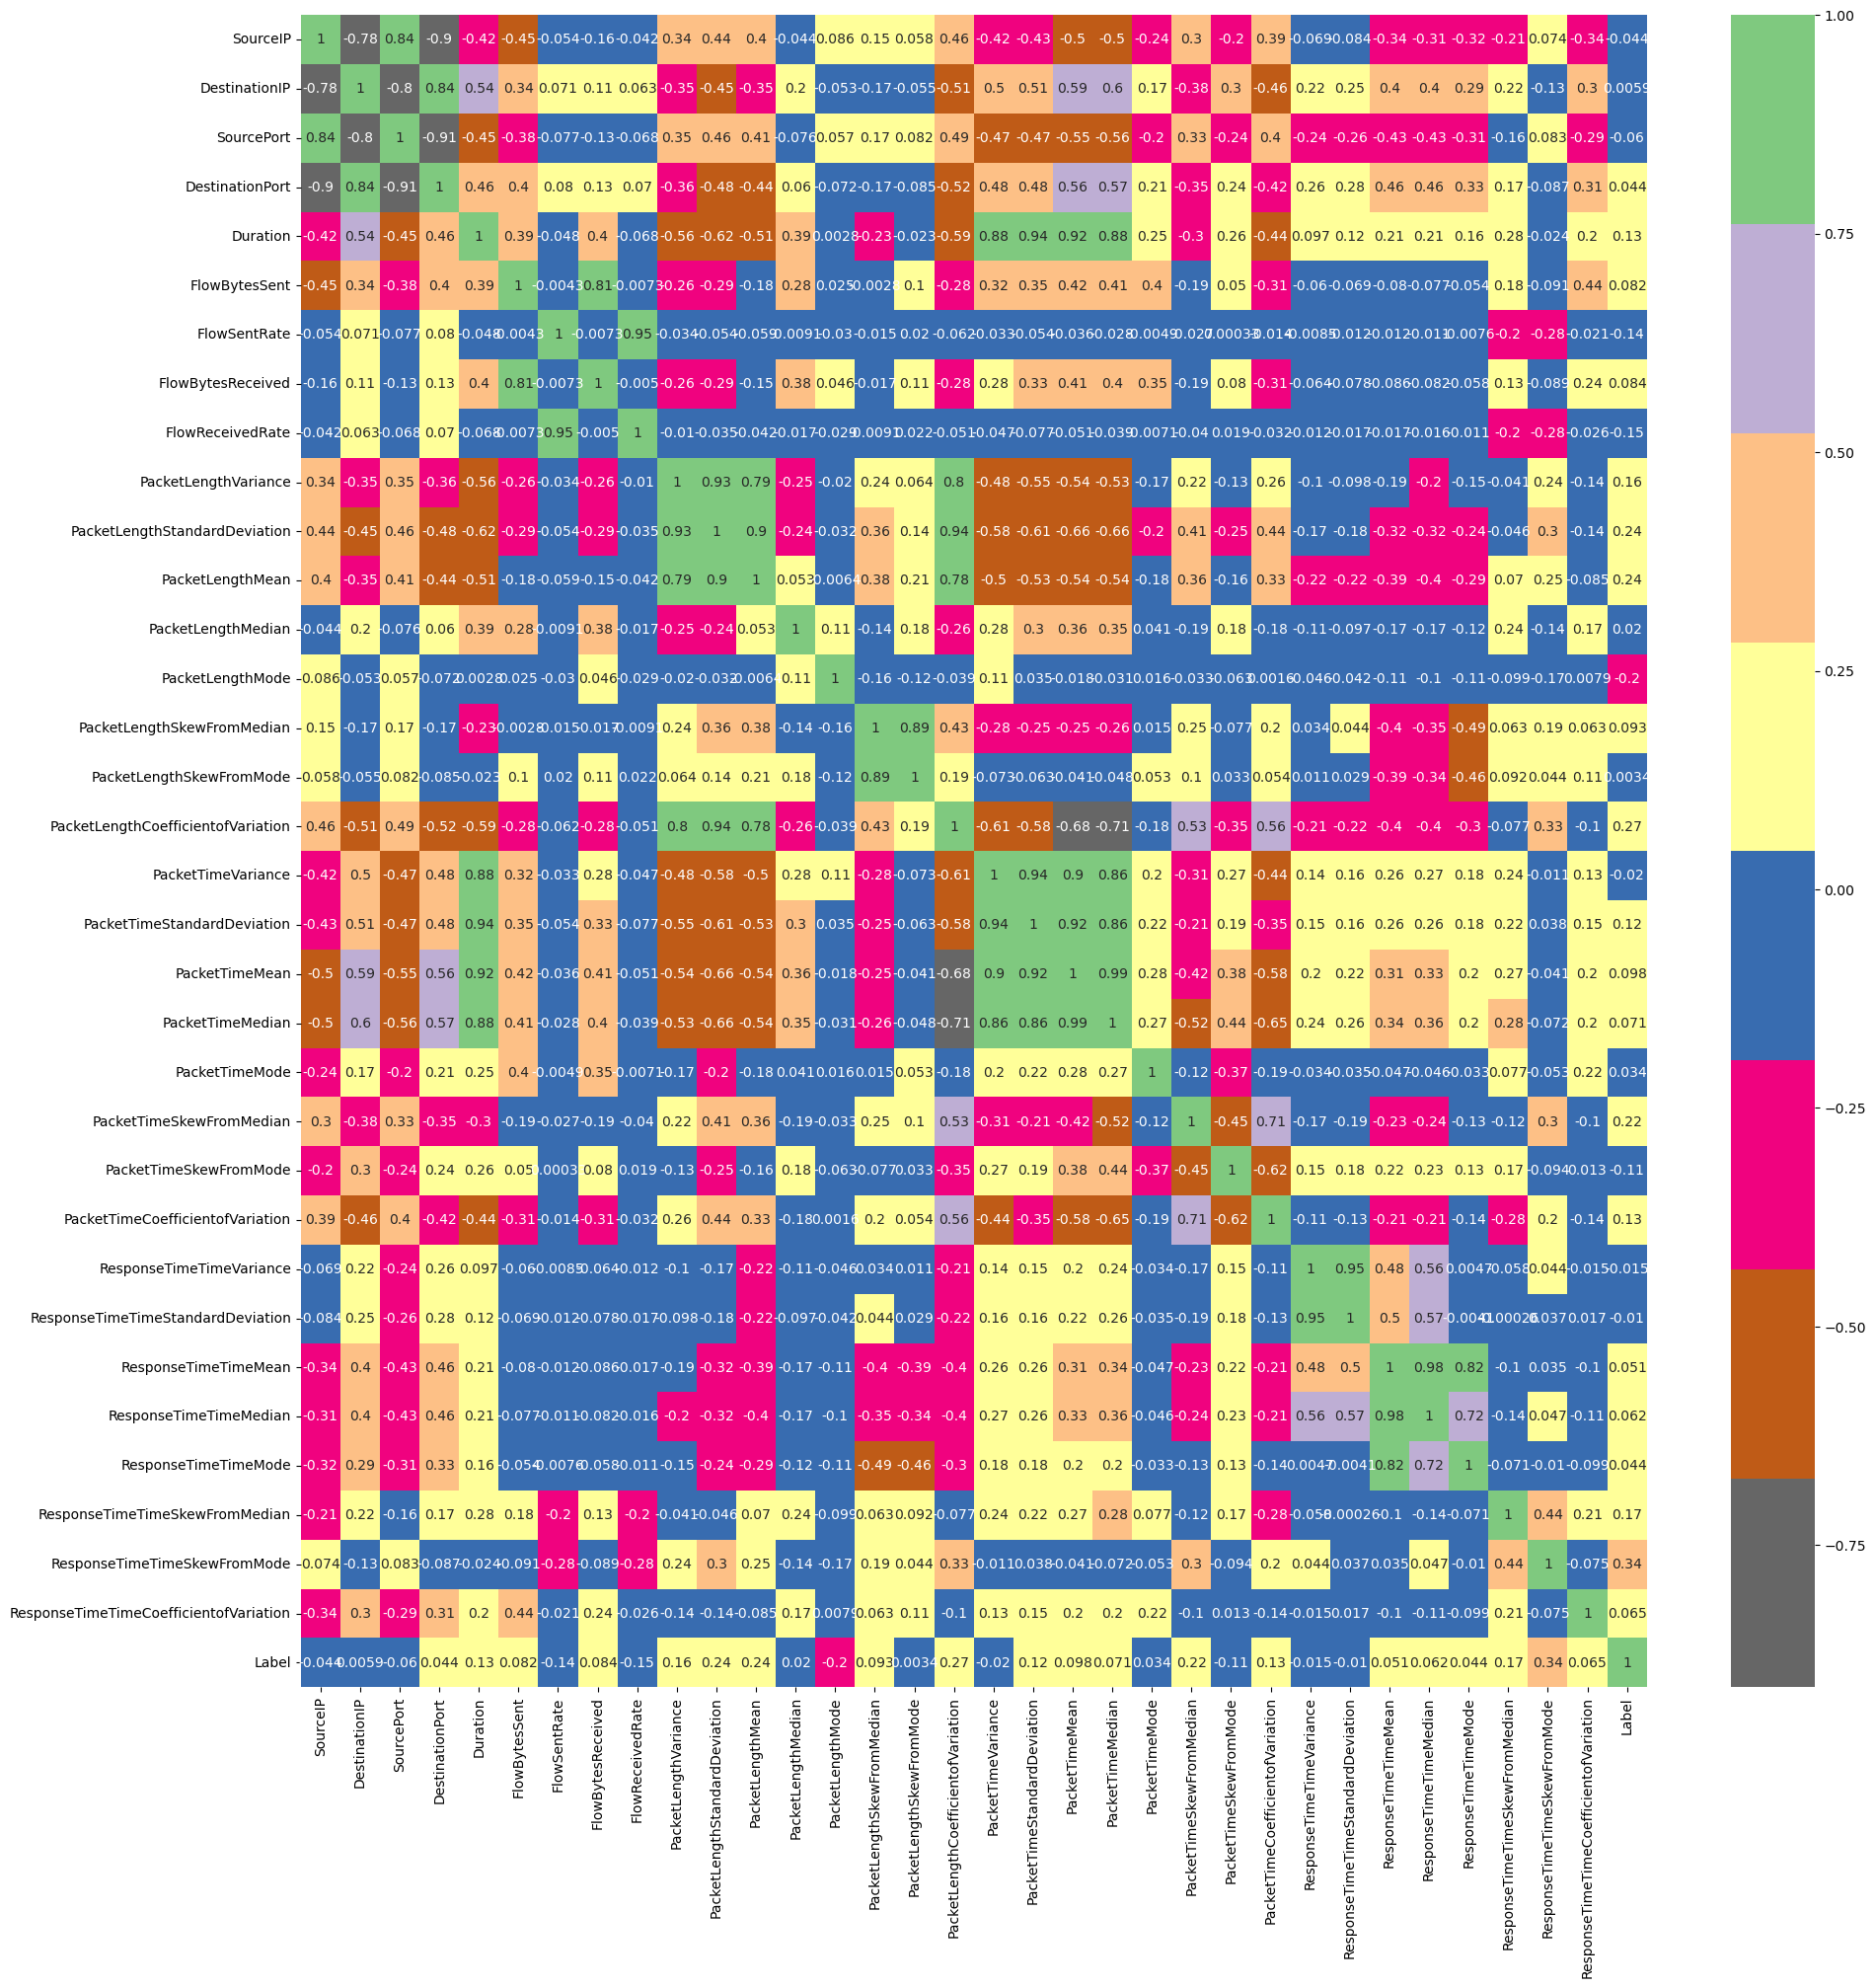

In [46]:
corr = df.corr()

fg = plt.figure(figsize=(22,22))

sns.heatmap(corr , annot=True , cmap=plt.cm.Accent_r)

**Creating function to get highly intercorrelated features**

In [47]:
def correlation(dataset , threshold):
    col_corr = set()
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i,j]) > threshold:
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
                
    return col_corr

In [48]:
corr_features = correlation(x_train , 0.7)

In [49]:
len(corr_features)

17

In [47]:
corr_features

{'DestinationIP',
 'DestinationPort',
 'FlowBytesReceived',
 'FlowReceivedRate',
 'PacketLengthCoefficientofVariation',
 'PacketLengthMean',
 'PacketLengthSkewFromMode',
 'PacketLengthStandardDeviation',
 'PacketTimeCoefficientofVariation',
 'PacketTimeMean',
 'PacketTimeMedian',
 'PacketTimeStandardDeviation',
 'PacketTimeVariance',
 'ResponseTimeTimeMedian',
 'ResponseTimeTimeMode',
 'ResponseTimeTimeStandardDeviation',
 'SourcePort'}

**Removing highly intercorrelated features**

In [120]:
x_train.drop(corr_features , axis=1 , inplace=True)

x_test.drop(corr_features , axis=1 , inplace=True)

In [50]:
x_train

,SourceIP,DestinationIP,SourcePort,DestinationPort,Duration,FlowBytesSent,FlowSentRate,FlowBytesReceived,FlowReceivedRate,PacketLengthVariance,...,PacketTimeSkewFromMode,PacketTimeCoefficientofVariation,ResponseTimeTimeVariance,ResponseTimeTimeStandardDeviation,ResponseTimeTimeMean,ResponseTimeTimeMedian,ResponseTimeTimeMode,ResponseTimeTimeSkewFromMedian,ResponseTimeTimeSkewFromMode,ResponseTimeTimeCoefficientofVariation
175878,134743044,3232240848,443,43610,120.498029,224355,1861.897675,127230,1055.867893,7158.270918,...,1.093624,0.808937,0.107084,0.327237,0.084768,0.000042,0.000013,0.776742,0.259003,3.860371
230563,3232240844,151587083,39976,443,0.204325,1085,5310.167625,4032,19733.268078,224634.645062,...,1.335661,0.748693,0.000066,0.008107,0.008950,0.008753,0.000025,0.072838,1.100880,0.905827
37501,3232240848,151587083,46346,443,34.088127,1875,55.004489,4896,143.627721,126668.888658,...,0.599817,1.667174,0.000060,0.007732,0.009625,0.015450,0.000024,-2.260113,1.241839,0.803249
113979,3232240784,151587083,60520,443,34.100154,3726,109.266369,6776,198.708780,82540.805213,...,0.519346,1.925500,0.000085,0.009234,0.010871,0.013706,0.000018,-0.920945,1.175313,0.849429
237868,3232240784,151587083,37296,443,18.318387,1510,82.430838,4550,248.384315,388678.247934,...,0.381383,2.622033,0.000033,0.005718,0.013109,0.015496,0.000334,-1.252846,2.234014,0.436219
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119879,3232240784,151587083,58086,443,33.584279,1739,51.780180,4760,141.732982,322210.652949,...,0.657243,1.521508,0.000045,0.006716,0.011642,0.015397,0.000010,-1.677790,1.731991,0.576874
259178,3232240852,151587083,58786,443,34.436756,1951,56.654582,4895,142.144632,123326.308594,...,0.656540,1.523137,0.000057,0.007544,0.009447,0.015317,0.000023,-2.334524,1.249184,0.798574
131932,3232240850,151587083,54312,443,33.363329,5392,161.614568,8088,242.421852,153368.828775,...,0.476426,2.098962,0.000061,0.007818,0.007522,0.001013,0.000004,2.497572,0.961588,1.039393
146867,3232240844,151587083,57134,443,33.761809,4285,126.918555,7025,208.075343,78429.103448,...,0.511025,1.956851,0.000054,0.007359,0.006860,0.001285,0.000032,2.273028,0.927875,1.072704


In [51]:
x_test

,SourceIP,DestinationIP,SourcePort,DestinationPort,Duration,FlowBytesSent,FlowSentRate,FlowBytesReceived,FlowReceivedRate,PacketLengthVariance,...,PacketTimeSkewFromMode,PacketTimeCoefficientofVariation,ResponseTimeTimeVariance,ResponseTimeTimeStandardDeviation,ResponseTimeTimeMean,ResponseTimeTimeMedian,ResponseTimeTimeMode,ResponseTimeTimeSkewFromMedian,ResponseTimeTimeSkewFromMode,ResponseTimeTimeCoefficientofVariation
77826,3232240850,151587083,56514,443,34.084361,1807,53.015516,4828,141.648541,145520.370987,...,0.627572,1.593442,5.266473e-05,0.007257,0.010387,0.015370,0.000085,-2.060067,1.419540,0.698689
97048,3232240847,134743044,57994,443,94.775271,496030,5233.749213,853055,9000.818367,8607.636728,...,-0.340695,0.575955,5.825777e-05,0.007633,0.008732,0.014771,0.000052,-2.373583,1.137225,0.874097
142036,3232240784,2959573634,50812,443,121.533168,12456,102.490540,22277,183.299756,99845.886771,...,1.319306,0.757974,5.735411e-02,0.239487,0.163602,0.029988,0.026663,1.673754,0.571800,1.463843
36369,3232240852,151587083,40682,443,33.883927,1807,53.329120,4895,144.463775,141408.773333,...,0.612474,1.632721,5.477343e-05,0.007401,0.010531,0.015263,0.000027,-1.918008,1.419331,0.702751
114156,2959573634,3232240784,443,40646,119.537443,805,6.734292,772,6.458227,109.580579,...,2.031735,0.492190,5.051662e+01,7.107504,10.051577,15.077268,0.000005,-2.121289,1.414220,0.707103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17968,3232240784,134743044,42578,443,120.140476,23760,197.768486,44716,372.197626,16811.455657,...,1.474786,0.678064,4.529735e-04,0.021283,0.017427,0.015328,0.015325,0.295909,0.098777,1.221255
141289,3232240753,2959573634,41708,443,177.001453,618,3.491497,315,1.779646,319.410000,...,1.225211,0.816186,2.745976e-07,0.000524,0.022108,0.021812,0.021667,1.692682,0.840934,0.023703
249851,3232240784,151587083,60684,443,90.047852,102178,1134.707800,185225,2056.961892,18285.187763,...,1.677287,0.596201,1.791592e-05,0.004233,0.016506,0.015584,0.015403,0.652930,0.260523,0.256440
157228,3232240751,134744072,43330,443,0.015586,171,10971.384576,105,6736.815090,338.000000,...,1.414213,0.707107,0.000000e+00,0.000000,0.015566,0.015566,0.015566,-10.000000,-10.000000,0.000000


In [52]:
x_train.shape , x_test.shape

((180660, 33), (88983, 33))

**Scaling the features using Robust scaler** 

In [44]:
rob = RobustScaler()

In [45]:
x_train_scaled = rob.fit_transform(x_train)

x_train_scaled

array([[-4.83984031e+07,  3.08065376e+09, -2.60472498e+00, ...,
         3.08895169e-01, -7.46072064e-01,  4.74801170e+00],
       [ 0.00000000e+00,  0.00000000e+00, -2.37266820e-01, ...,
         4.41360754e-02,  1.10259110e-01,  1.45666228e-01],
       [ 6.25000000e-02,  0.00000000e+00,  1.44204569e-01, ...,
        -8.33355857e-01,  2.53639034e-01, -1.41211767e-02],
       ...,
       [ 9.37500000e-02,  0.00000000e+00,  6.21253406e-01, ...,
         9.56150149e-01, -3.14239617e-02,  3.53724596e-01],
       [ 0.00000000e+00,  0.00000000e+00,  7.90250621e-01, ...,
         8.71692478e-01, -6.57153406e-02,  4.05612735e-01],
       [ 1.56250000e-02,  0.00000000e+00,  5.86998832e-01, ...,
        -6.17427647e-02, -2.02568961e-01,  6.89114670e-01]])

In [46]:
x_test_scaled = rob.fit_transform(x_test)

x_test_scaled

array([[ 9.37500000e-02,  0.00000000e+00,  7.49611755e-01, ...,
        -7.63146299e-01,  4.31070430e-01, -1.78078840e-01],
       [ 4.68750000e-02, -1.68440390e+07,  8.38012185e-01, ...,
        -8.81414641e-01,  1.44007311e-01,  9.73248182e-02],
       [-9.37500000e-01,  2.80798655e+09,  4.09031179e-01, ...,
         6.45370079e-01, -4.30927065e-01,  1.02326683e+00],
       ...,
       [-9.37500000e-01,  0.00000000e+00,  9.98685940e-01, ...,
         2.60282579e-01, -7.47438398e-01, -8.72441083e-01],
       [-1.45312500e+00, -1.68430110e+07, -3.78688329e-02, ...,
        -3.75834306e+00, -1.11805254e+01, -1.27506911e+00],
       [ 7.81250000e-02,  0.00000000e+00, -1.06677816e-01, ...,
        -4.12458443e-01,  2.90359642e-01, -5.19399989e-02]])

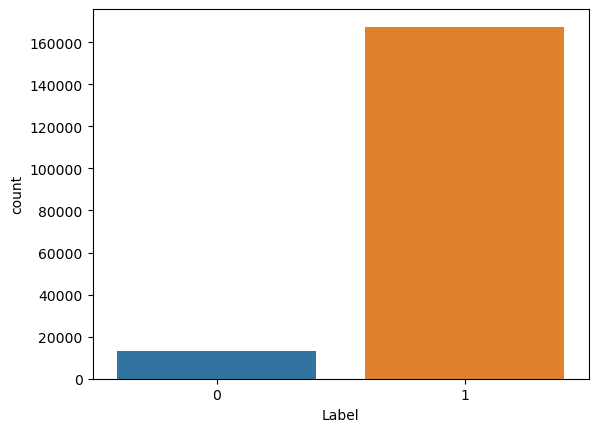

In [57]:
sns.countplot(y_train)
plt.show()

## Using classification algorithms without balancing data

## Random Forest Classifier

In [47]:
rf = RandomForestClassifier()

In [48]:
rf.fit(x_train_scaled , y_train)
pred = rf.predict(x_test_scaled)
print('Accuracy of Random Forest : ',accuracy_score(y_test , pred))
print()
print(classification_report(y_test , pred))
print()
print('Confusion metrics:')
print(confusion_matrix(y_test , pred))

Accuracy of Random Forest :  0.9999438094917007

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6502
           1       1.00      1.00      1.00     82481

    accuracy                           1.00     88983
   macro avg       1.00      1.00      1.00     88983
weighted avg       1.00      1.00      1.00     88983


Confusion metrics:
[[ 6499     3]
 [    2 82479]]


## XGB classifier

In [49]:
xgb = XGBClassifier()

In [50]:
xgb.fit(x_train_scaled , y_train)
pred = xgb.predict(x_test_scaled)
print('Accuracy of XGB classifier : ',accuracy_score(y_test , pred))
print()
print(classification_report(y_test , pred))
print()
print('Confusion metrics:')
print(confusion_matrix(y_test , pred))

Accuracy of XGB classifier :  0.9999775237966803

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6502
           1       1.00      1.00      1.00     82481

    accuracy                           1.00     88983
   macro avg       1.00      1.00      1.00     88983
weighted avg       1.00      1.00      1.00     88983


Confusion metrics:
[[ 6500     2]
 [    0 82481]]


## Using classification algorithms After balancing data

### Balancing data using Under-sampling (NearMiss)

In [64]:
nm = NearMiss()
x_train , y_train = nm.fit_resample(x_train_scaled , y_train)

**We balanced the data**

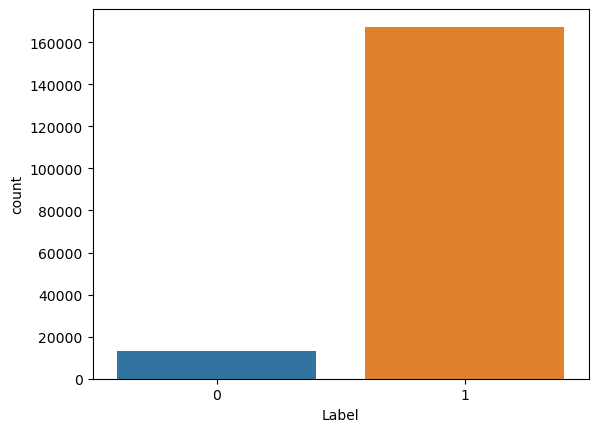

In [62]:
sns.countplot(y_train)

plt.show()

In [66]:
x_train.shape , y_train.shape

((26610, 16), (26610,))

## Random Forest

In [67]:
rf = RandomForestClassifier()

In [69]:
rf.fit(x_train , y_train)
pred = rf.predict(x_test_scaled)
print('Accuracy of naive bayes : ',accuracy_score(y_test , pred))
print()
print(classification_report(y_test , pred))
print()
print('Confusion metrics:')
print(confusion_matrix(y_test , pred))

Accuracy of naive bayes :  0.8371486688468583

              precision    recall  f1-score   support

           0       0.31      1.00      0.47      6502
           1       1.00      0.82      0.90     82481

    accuracy                           0.84     88983
   macro avg       0.65      0.91      0.69     88983
weighted avg       0.95      0.84      0.87     88983


Confusion metrics:
[[ 6502     0]
 [14491 67990]]


## XGB Classifier

In [70]:
xgb = XGBClassifier()

In [71]:
xgb.fit(x_train , y_train)
pred = xgb.predict(x_test_scaled)
print('Accuracy of XGB classifier : ',accuracy_score(y_test , pred))
print()
print(classification_report(y_test , pred))
print()
print('Confusion metrics:')
print(confusion_matrix(y_test , pred))

Accuracy of XGB classifier :  0.8448804827888473

              precision    recall  f1-score   support

           0       0.32      1.00      0.49      6502
           1       1.00      0.83      0.91     82481

    accuracy                           0.84     88983
   macro avg       0.66      0.92      0.70     88983
weighted avg       0.95      0.84      0.88     88983


Confusion metrics:
[[ 6502     0]
 [13803 68678]]


**As per above results, we can conclude that RF and XGB giving good accuracy and performance
Now we can perform Hyperparameter Tuning to Improve performance of those models**

### 1. Random Forest with Hyperparameter tuning

## GridSearchCV

In [62]:
rf = RandomForestClassifier()

In [64]:
n_estimators = [20,60,100,120]

max_features = [0.2,0.6,1.0]

max_depth = [2,8,None]

max_samples = [0.5,0.75,1.0]

In [65]:
param_grid = {'n_estimators' : n_estimators ,
              'max_features' : max_features ,
              'max_depth'  : max_depth ,
               'max_samples' : max_samples
             }

param_grid

{'n_estimators': [20, 60, 100, 120],
 'max_features': [0.2, 0.6, 1.0],
 'max_depth': [2, 8, None],
 'max_samples': [0.5, 0.75, 1.0]}

In [66]:
grid = GridSearchCV(estimator = rf ,
                    param_grid = param_grid ,
                    cv= 5,
                    verbose = 1 ,
                    n_jobs = -1)



In [67]:
grid.fit(x_train , y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [2, 8, None],
                         'max_features': [0.2, 0.6, 1.0],
                         'max_samples': [0.5, 0.75, 1.0],
                         'n_estimators': [20, 60, 100, 120]},
             verbose=1)

In [69]:
grid.best_params_

{'max_depth': 8, 'max_features': 0.6, 'max_samples': 0.75, 'n_estimators': 20}

In [70]:
grid.best_score_

0.9999252895031752

**Accuracy using above best parameters**

In [94]:
rf = RandomForestClassifier(n_estimators=50, max_depth=8 , max_features=0.8 , max_samples=0.80)

In [95]:
rf.fit(x_train , y_train)
pred = rf.predict(x_test_scaled)
print('Accuracy of naive bayes : ',accuracy_score(y_test , pred))
print()
print(classification_report(y_test , pred))
print()
print('Confusion metrics:')
print(confusion_matrix(y_test , pred))

Accuracy of naive bayes :  0.8538484879134217

              precision    recall  f1-score   support

           0       0.33      1.00      0.50      6502
           1       1.00      0.84      0.91     82481

    accuracy                           0.85     88983
   macro avg       0.67      0.92      0.71     88983
weighted avg       0.95      0.85      0.88     88983


Confusion metrics:
[[ 6502     0]
 [13005 69476]]


In [96]:
rf.feature_importances_

array([7.84510673e-01, 2.60365773e-03, 3.08542843e-03, 4.04376434e-04,
       1.60113124e-02, 1.16651059e-01, 5.29496020e-02, 2.04972372e-03,
       1.05451704e-02, 5.72158301e-03, 3.35591647e-03, 3.97480352e-04,
       1.53715198e-03, 9.87996724e-06, 7.10479739e-05, 9.59377899e-05])

**We are getting less precision and f1 score**

## Lightgbm with Hyperparameter Tuning

In [98]:
clf = lgm.LGBMClassifier()
clf.fit(x_train , y_train)
pred = clf.predict(x_test_scaled)
print('Accuracy of LightGBM : ',accuracy_score(y_test , pred))
print()
print(classification_report(y_test , pred))
print()
print('Confusion metrics:')
print(confusion_matrix(y_test , pred))

Accuracy of LightGBM :  0.8629963026645538

              precision    recall  f1-score   support

           0       0.35      1.00      0.52      6502
           1       1.00      0.85      0.92     82481

    accuracy                           0.86     88983
   macro avg       0.67      0.93      0.72     88983
weighted avg       0.95      0.86      0.89     88983


Confusion metrics:
[[ 6502     0]
 [12191 70290]]


### Hyperparameter tuning (GridSearchCV)

In [78]:
n_estimators = [100,200,500,1000]

max_depth = [2,5,8]

#learning_rate = [0.01,0.02]

num_leaves = [20,50,100,500]

min_data_in_leaf = [100,200,500]

In [79]:
params = {'n_estimators' : n_estimators ,
          'max_depth' : max_depth ,
          'num_leaves' : num_leaves ,
          'min_data_in_leaf' : min_data_in_leaf
         }
params

{'n_estimators': [100, 200, 500, 1000],
 'max_depth': [2, 5, 8],
 'num_leaves': [20, 50, 100, 500],
 'min_data_in_leaf': [100, 200, 500]}

In [80]:
clf = lgm.LGBMClassifier()

In [81]:
grid = GridSearchCV(estimator=clf , 
                    param_grid= params ,
                    cv = 5 ,
                    verbose=2,
                    n_jobs= -1)

In [82]:
grid.fit(x_train , y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


GridSearchCV(cv=5, estimator=LGBMClassifier(), n_jobs=-1,
             param_grid={'max_depth': [2, 5, 8],
                         'min_data_in_leaf': [100, 200, 500],
                         'n_estimators': [100, 200, 500, 1000],
                         'num_leaves': [20, 50, 100, 500]},
             verbose=2)

In [83]:
grid.best_params_

{'max_depth': 2,
 'min_data_in_leaf': 100,
 'n_estimators': 200,
 'num_leaves': 20}

In [84]:
grid.best_score_

1.0

In [85]:
# clf.feature_importances_

**We got the optimal parameters**

In [99]:
clf = lgm.LGBMClassifier(num_leaves=30 , n_estimators=500, max_depth=6)

In [100]:
clf.fit(x_train , y_train)
pred = clf.predict(x_test_scaled)
print('Accuracy of LightGBM : ',accuracy_score(y_test , pred))
print()
print(classification_report(y_test , pred))
print()
print('Confusion metrics:')
print(confusion_matrix(y_test , pred))

Accuracy of LightGBM :  0.8629513502579145

              precision    recall  f1-score   support

           0       0.35      1.00      0.52      6502
           1       1.00      0.85      0.92     82481

    accuracy                           0.86     88983
   macro avg       0.67      0.93      0.72     88983
weighted avg       0.95      0.86      0.89     88983


Confusion metrics:
[[ 6502     0]
 [12195 70286]]


**We got better performance for these parameters....**

## XGBoost 

In [101]:
xg = XGBClassifier()

In [102]:
xg.fit(x_train , y_train)
pred = xg.predict(x_test_scaled)
print('Accuracy of LightGBM : ',accuracy_score(y_test , pred))
print()
print(classification_report(y_test , pred))
print()
print('Confusion metrics:')
print(confusion_matrix(y_test , pred))

Accuracy of LightGBM :  0.8448804827888473

              precision    recall  f1-score   support

           0       0.32      1.00      0.49      6502
           1       1.00      0.83      0.91     82481

    accuracy                           0.84     88983
   macro avg       0.66      0.92      0.70     88983
weighted avg       0.95      0.84      0.88     88983


Confusion metrics:
[[ 6502     0]
 [13803 68678]]


## XGBoost with hyperparameter Tuning

In [ ]:
n_estimators = [100,200,500,1000]

max_depth = [2,5,8]

learning_rate = [0.01,0.02,0.03]

num_leaves = [20,50,100,500]

# min_data_in_leaf = [100,200,500]

In [ ]:
params = {'n_estimators' : n_estimators ,
          'max_depth' : max_depth ,
          'num_leaves' : num_leaves ,
          'learning_rate' : learning_rate,
         }
params

In [ ]:
xgb = XGBClassifier()

In [ ]:
grid = GridSearchCV(estimator=xgb , 
                    param_grid= params ,
                    cv = 5 ,
                    verbose=2,
                    n_jobs= -1)

In [ ]:
grid.fit(x_train , y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


In [ ]:
grid.best_params_

In [ ]:
grid.best_score_

## Balancing the dataset using Over-sampling

In [52]:
ad = ADASYN()

x_train , y_train = ad.fit_resample(x_train_scaled , y_train)

<AxesSubplot:xlabel='Label', ylabel='count'>

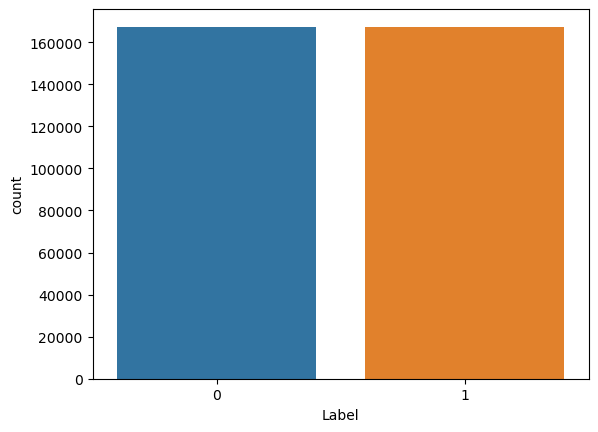

In [53]:
sns.countplot(y_train)

In [54]:
x_train.shape , y_train.shape

((334511, 33), (334511,))

In [55]:
rf = RandomForestClassifier(n_estimators=20, max_depth=8 , max_features=0.6 , max_samples=0.75)

In [56]:
rf.fit(x_train , y_train)
pred = rf.predict(x_test_scaled)
print('Accuracy of naive bayes : ',accuracy_score(y_test , pred))
print()
print(classification_report(y_test , pred))
print()
print('Confusion metrics:')
print(confusion_matrix(y_test , pred))

Accuracy of naive bayes :  0.9983255228526797

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      6502
           1       1.00      1.00      1.00     82481

    accuracy                           1.00     88983
   macro avg       0.99      1.00      0.99     88983
weighted avg       1.00      1.00      1.00     88983


Confusion metrics:
[[ 6500     2]
 [  147 82334]]


In [57]:
rf.feature_importances_

array([1.98295948e-01, 8.08371433e-03, 1.48223673e-04, 9.12696104e-04,
       2.99363920e-02, 7.20456063e-03, 8.88812138e-02, 1.18058089e-02,
       3.99148059e-02, 1.89103580e-03, 4.40297924e-03, 8.18413338e-03,
       2.21202192e-02, 4.72559951e-01, 8.05678829e-04, 2.35537381e-02,
       9.75957734e-03, 5.70068834e-03, 2.00507753e-02, 6.18608033e-03,
       2.88524940e-03, 8.61246493e-03, 3.06850617e-04, 3.93165487e-03,
       5.26221349e-04, 5.30252948e-04, 1.37619630e-03, 1.54946586e-03,
       4.22878642e-03, 5.85846377e-04, 4.58791731e-04, 1.40702750e-02,
       5.39723502e-04])

In [60]:
clf = lgm.LGBMClassifier(num_leaves=20 , n_estimators=200, max_depth=2)

In [61]:
# clf = lgm.LGBMClassifier()
clf.fit(x_train , y_train)
pred = clf.predict(x_test_scaled)
print('Accuracy of LightGBM : ',accuracy_score(y_test , pred))
print()
print(classification_report(y_test , pred))
print()
print('Confusion metrics:')
print(confusion_matrix(y_test , pred))

Accuracy of LightGBM :  1.0

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6502
           1       1.00      1.00      1.00     82481

    accuracy                           1.00     88983
   macro avg       1.00      1.00      1.00     88983
weighted avg       1.00      1.00      1.00     88983


Confusion metrics:
[[ 6502     0]
 [    0 82481]]


In [62]:
clf.feature_importances_

array([202, 116,   0,   0,   8,   0,  28,   9,  29,   5,   2,   2,  35,
        88,   0,   7,   0,   0,   6,   8,   1,  13,   0,   0,   1,   0,
         0,   3,  25,   1,  10,   1,   0])